# Data Processing


In [1]:
#%pip install wfdb

In [2]:
#%pip install keras

In [3]:
#%pip install tensorflow

In [4]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, re, pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models



# Visualization of the Data Provided

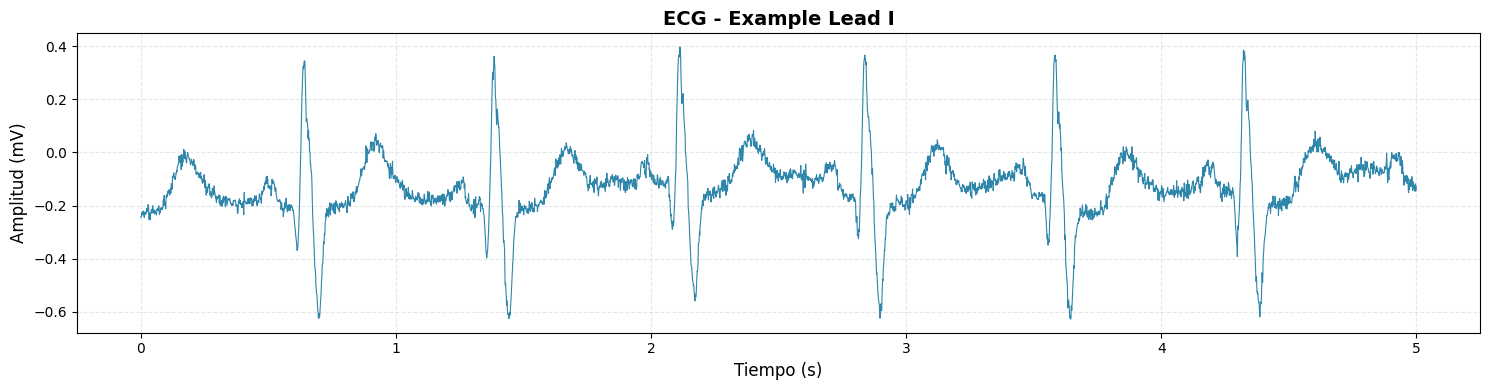

In [5]:

record = wfdb.rdrecord('Data/ptb-diagnostic-ecg-database/patient001/s0010_re')
signal = record.p_signal
fs = record.fs  

channel = 0
duration_sec = 5
lead_name = 'Example Lead I'

samples = int(duration_sec * fs)
time = np.arange(samples) / fs

plt.figure(figsize=(15, 4))
plt.plot(time, signal[:samples, channel], linewidth=0.8, color='#2E86AB')
plt.xlabel('Tiempo (s)', fontsize=12)
plt.ylabel('Amplitud (mV)', fontsize=12)
plt.title(f'ECG - {lead_name or record.sig_name[channel]}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

Form of the signal: (38400, 15)
Channel: ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'vx', 'vy', 'vz']


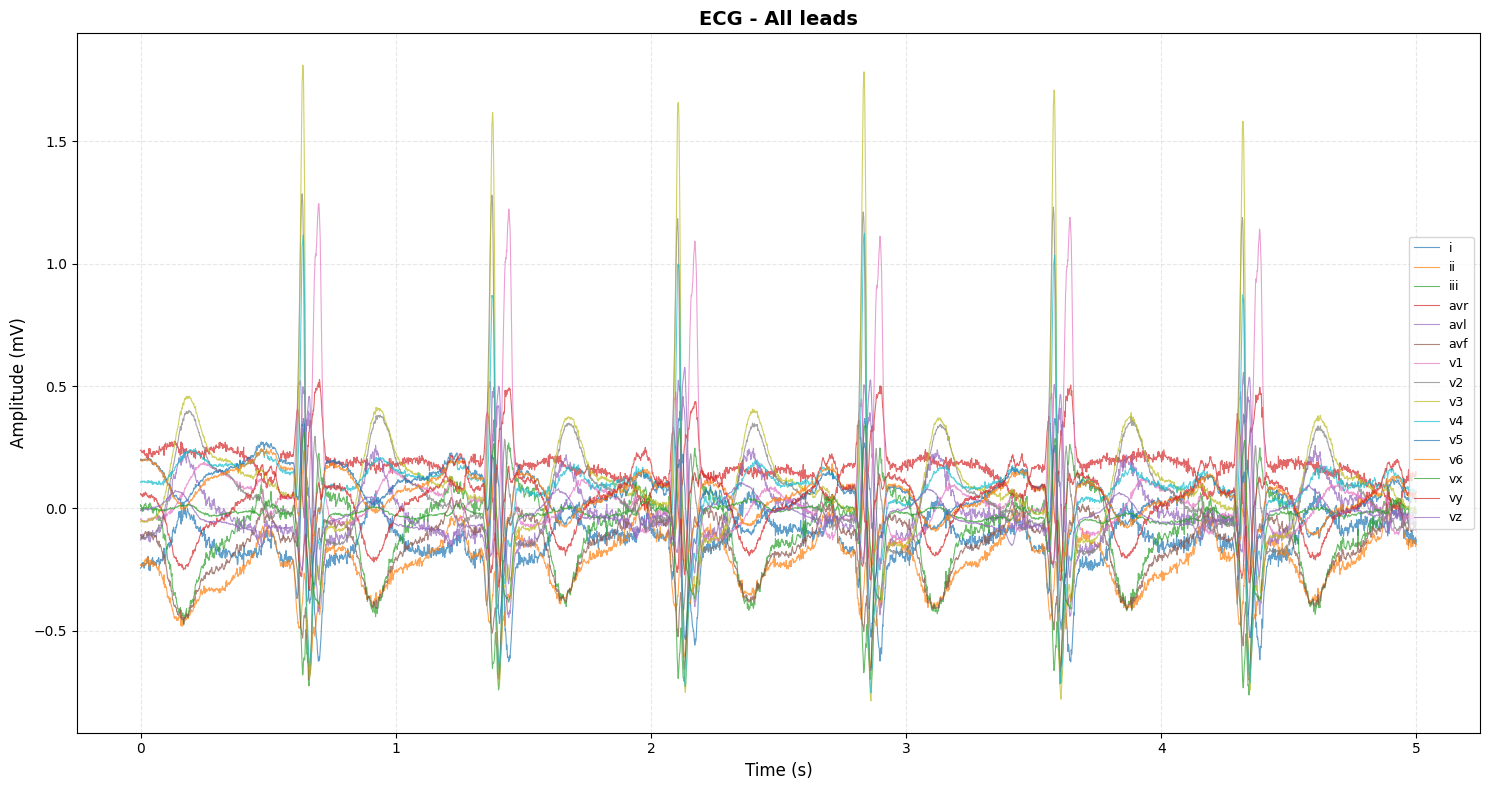

In [6]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# Leer un registro
record = wfdb.rdrecord('Data/ptb-diagnostic-ecg-database/patient001/s0010_re')
signal = record.p_signal
fs = record.fs

print("Form of the signal:", signal.shape)
print("Channel:", record.sig_name)

# Configuración
duration_sec = 5
samples = int(duration_sec * fs)
time = np.arange(samples) / fs
plt.figure(figsize=(15, 8))

for i in range(signal.shape[1]):
    plt.plot(time, signal[:samples, i], linewidth=0.8, label=record.sig_name[i], alpha=0.7)

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude (mV)', fontsize=12)
plt.title('ECG - All leads', fontsize=14, fontweight='bold')
plt.legend(loc='right', fontsize=9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

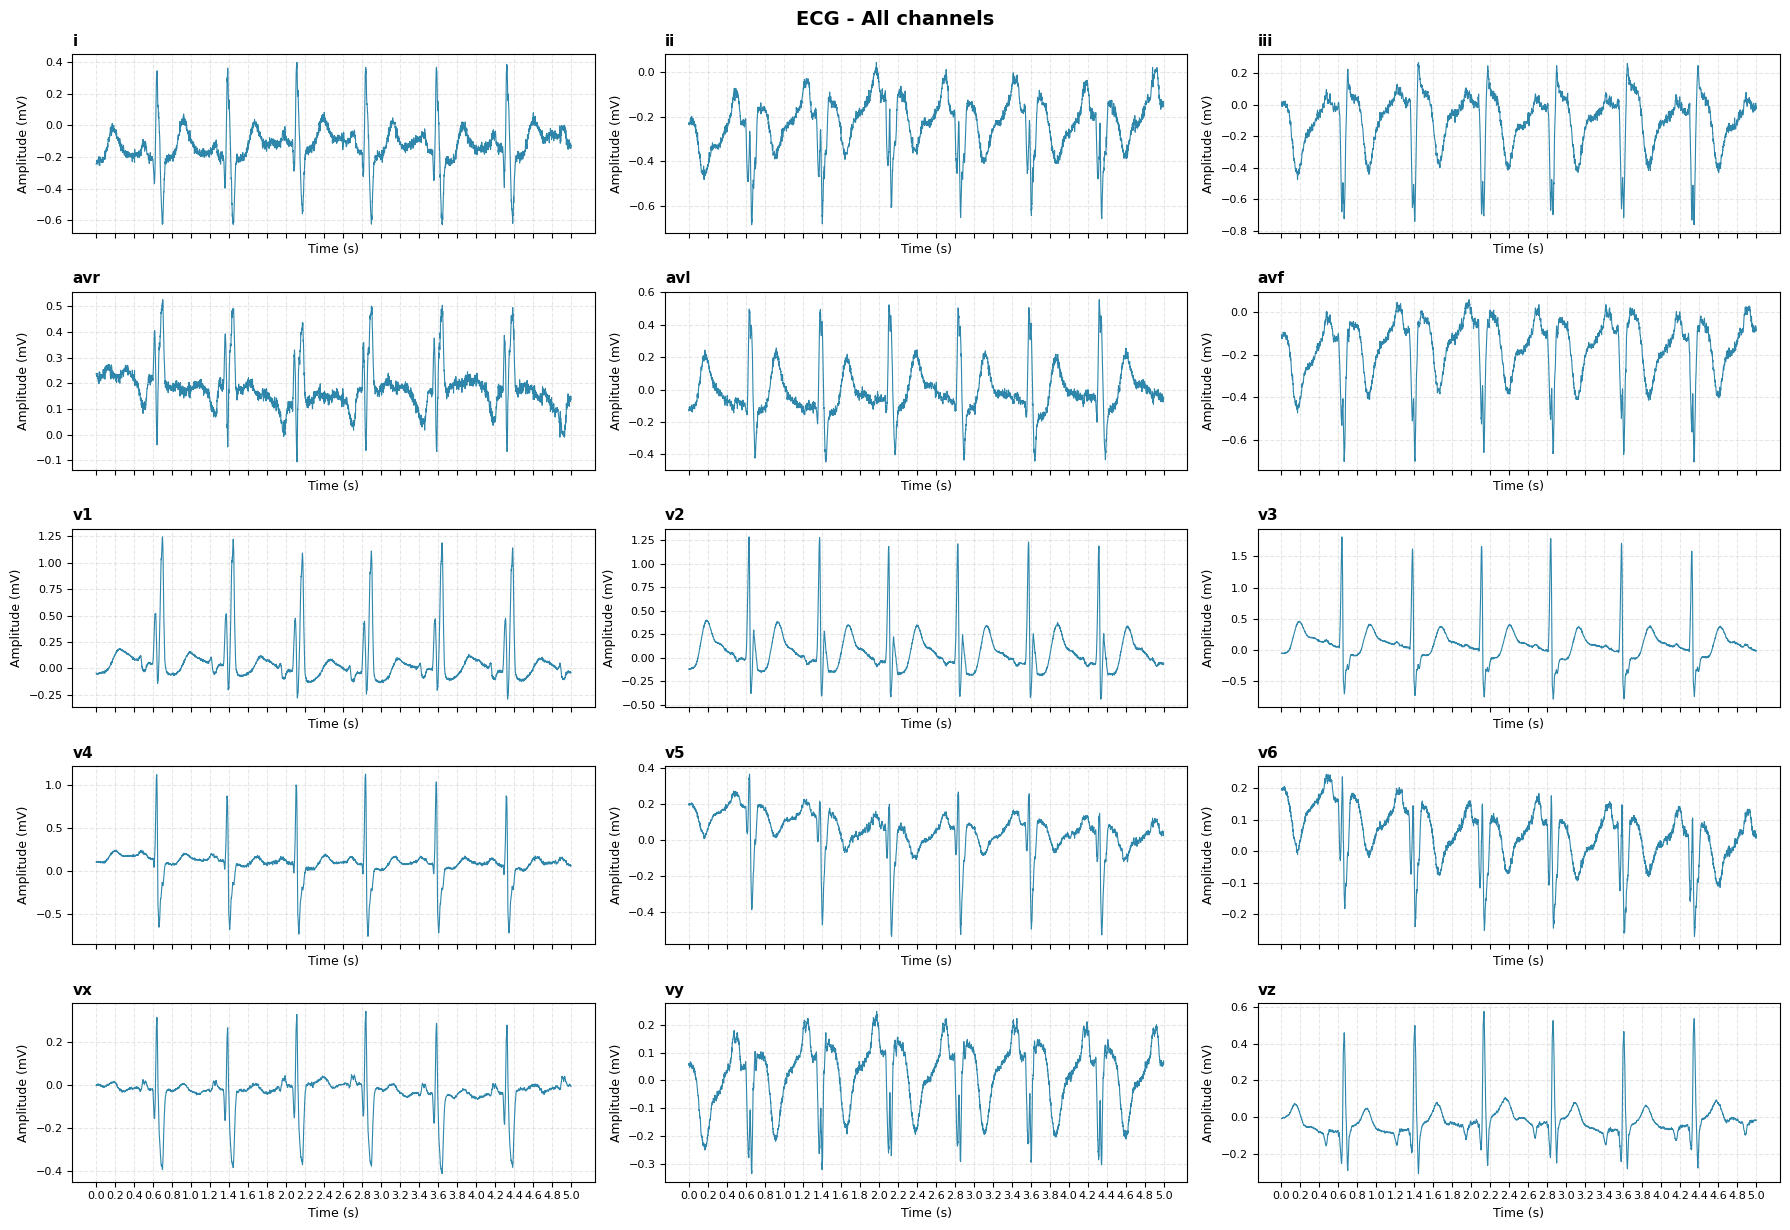

In [7]:

record = wfdb.rdrecord('Data/ptb-diagnostic-ecg-database/patient001/s0010_re')
signal = record.p_signal
fs = record.fs  

duration_sec = 5
samples = int(duration_sec * fs)
time = np.arange(samples) / fs

n_channels = signal.shape[1]


n_cols = 3 
n_rows = int(np.ceil(n_channels / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 2.5*n_rows), sharex=True, sharey=False)
axes = axes.flatten()  

for i in range(n_channels):
    axes[i].plot(time, signal[:samples, i], linewidth=0.8, color='#2E86AB')
    axes[i].set_ylabel('Amplitude (mV)', fontsize=9)
    axes[i].set_xlabel('Time (s)', fontsize=9)
    axes[i].set_title(record.sig_name[i], fontsize=11, loc='left', fontweight='bold')
    axes[i].set_xticks(np.arange(0, duration_sec + 0.2, 0.2))
    axes[i].grid(True, alpha=0.3, linestyle='--')
    axes[i].tick_params(axis='both', labelsize=8)


plt.suptitle('ECG - All channels', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [8]:
base_dir = 'Data/ptb-diagnostic-ecg-database' 
out_signals = 'Data/signals_npy'
os.makedirs(out_signals, exist_ok=True)

In [9]:
def to_key(s):
    s = s.strip('# ').lower()
    s = s.replace('(localization)','localization').replace('(at rest)','at_rest').replace('(load)','load')
    return re.sub(r'[^a-z0-9]+','_',s).strip('_')

def parse_comments(comments):
    d={}
    for c in comments or []:
        if ':' in c:
            k,v = c.split(':',1)
            d[to_key(k)] = v.strip()
    return d

def map_primary_label(meta):
    raw = (meta.get('reason_for_admission') or meta.get('diagnose') or '').lower()
    raw = raw.replace('heartfailure','heart failure').replace('arrhythmia','dysrhythmia')
    if 'healthy control' in raw: return 'Healthy controls'
    if 'myocardial infarction' in raw: return 'Myocardial infarction'
    if 'cardiomyopathy' in raw or 'heart failure' in raw: return 'Cardiomyopathy/Heart failure'
    if 'bundle branch block' in raw: return 'Bundle branch block'
    if 'dysrhythmia' in raw: return 'Dysrhythmia'
    if 'hypertrophy' in raw: return 'Myocardial hypertrophy'
    if 'valvular' in raw: return 'Valvular heart disease'
    if 'myocarditis' in raw: return 'Myocarditis'
    return 'Miscellaneous'


In [ ]:

rows=[]
for patient in sorted(os.listdir(base_dir)):
    pdir = os.path.join(base_dir, patient)
    if not os.path.isdir(pdir):
        continue

    for f in sorted(os.listdir(pdir)):
        if not f.endswith('.hea'):
            continue

        rec = f[:-4]
        stem = os.path.join(pdir, rec)

        try:
            hdr = wfdb.rdheader(stem)
            recd = wfdb.rdrecord(stem)
            meta = parse_comments(hdr.comments)
            label = map_primary_label(meta)

            sig = recd.p_signal
            n_samples, n_leads = sig.shape
            npy_path = os.path.join(out_signals, f'{patient}_{rec}.npy')
            np.save(npy_path, sig)

            def num(x): 
                return pd.to_numeric(x, errors='coerce')
            rows.append({
                'patient_id': patient,
                'record': rec,
                'base_path': stem,
                'n_samples': n_samples,
                'n_leads': n_leads,
                'fs': hdr.fs,
                'sig_name': hdr.sig_name,
                'signal_path': npy_path,
                'diagnosis_class': label,
                'is_MI': 1 if label == 'Myocardial infarction' else 0,
                'age': num(meta.get('age')),
                'sex': meta.get('sex'),
                'reason_for_admission': meta.get('reason_for_admission'),
                'acute_infarction_localization': meta.get('acute_infarction_localization'),
                'former_infarction_localization': meta.get('former_infarction_localization'),
                'additional_diagnoses': meta.get('additional_diagnoses'),
                'smoker': 1 if str(meta.get('smoker','')).lower().startswith('y') else 0
            })

        except Exception as e:
            print( stem, e)

df = pd.DataFrame(rows)
print(df.shape)
df.head()

(549, 17)


,patient_id,record,base_path,n_samples,n_leads,fs,sig_name,signal_path,diagnosis_class,is_MI,age,sex,reason_for_admission,acute_infarction_localization,former_infarction_localization,additional_diagnoses,smoker
0,patient001,s0010_re,Data/ptb-diagnostic-ecg-database\patient001\s0...,38400,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient001_s0010_re.npy,Myocardial infarction,1,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,0
1,patient001,s0014lre,Data/ptb-diagnostic-ecg-database\patient001\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient001_s0014lre.npy,Myocardial infarction,1,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,0
2,patient001,s0016lre,Data/ptb-diagnostic-ecg-database\patient001\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient001_s0016lre.npy,Myocardial infarction,1,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,0
3,patient002,s0015lre,Data/ptb-diagnostic-ecg-database\patient002\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient002_s0015lre.npy,Myocardial infarction,1,58.0,female,Myocardial infarction,anterior,no,"Arterial hypertension, Adiposis hepatis, Gastr...",1
4,patient003,s0017lre,Data/ptb-diagnostic-ecg-database\patient003\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient003_s0017lre.npy,Myocardial infarction,1,63.0,male,Myocardial infarction,infero-postero-lateral,no,no,1


In [11]:
df = pd.DataFrame(rows)
print(df.shape)
print(df.head())

(549, 17)
   patient_id    record                                          base_path  \
0  patient001  s0010_re  Data/ptb-diagnostic-ecg-database\patient001\s0...   
1  patient001  s0014lre  Data/ptb-diagnostic-ecg-database\patient001\s0...   
2  patient001  s0016lre  Data/ptb-diagnostic-ecg-database\patient001\s0...   
3  patient002  s0015lre  Data/ptb-diagnostic-ecg-database\patient002\s0...   
4  patient003  s0017lre  Data/ptb-diagnostic-ecg-database\patient003\s0...   

   n_samples  n_leads    fs  \
0      38400       15  1000   
1     115200       15  1000   
2     115200       15  1000   
3     115200       15  1000   
4     115200       15  1000   

                                            sig_name  \
0  [i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...   
1  [i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...   
2  [i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...   
3  [i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...   
4  [i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...  

In [12]:
df.head()

,patient_id,record,base_path,n_samples,n_leads,fs,sig_name,signal_path,diagnosis_class,is_MI,age,sex,reason_for_admission,acute_infarction_localization,former_infarction_localization,additional_diagnoses,smoker
0,patient001,s0010_re,Data/ptb-diagnostic-ecg-database\patient001\s0...,38400,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient001_s0010_re.npy,Myocardial infarction,1,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,0
1,patient001,s0014lre,Data/ptb-diagnostic-ecg-database\patient001\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient001_s0014lre.npy,Myocardial infarction,1,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,0
2,patient001,s0016lre,Data/ptb-diagnostic-ecg-database\patient001\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient001_s0016lre.npy,Myocardial infarction,1,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,0
3,patient002,s0015lre,Data/ptb-diagnostic-ecg-database\patient002\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient002_s0015lre.npy,Myocardial infarction,1,58.0,female,Myocardial infarction,anterior,no,"Arterial hypertension, Adiposis hepatis, Gastr...",1
4,patient003,s0017lre,Data/ptb-diagnostic-ecg-database\patient003\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient003_s0017lre.npy,Myocardial infarction,1,63.0,male,Myocardial infarction,infero-postero-lateral,no,no,1


In [13]:
df['diagnosis_class'].value_counts()


diagnosis_class
Myocardial infarction           368
Healthy controls                 80
Miscellaneous                    31
Cardiomyopathy/Heart failure     20
Bundle branch block              17
Dysrhythmia                      16
Myocardial hypertrophy            7
Valvular heart disease            6
Myocarditis                       4
Name: count, dtype: int64

In [14]:

df_unique = df.groupby('patient_id')['diagnosis_class'].first().reset_index()
df_unique['diagnosis_class'].value_counts()

diagnosis_class
Myocardial infarction           148
Healthy controls                 52
Miscellaneous                    26
Cardiomyopathy/Heart failure     18
Bundle branch block              15
Dysrhythmia                      14
Myocardial hypertrophy            7
Valvular heart disease            6
Myocarditis                       4
Name: count, dtype: int64

In [15]:
df.columns

Index(['patient_id', 'record', 'base_path', 'n_samples', 'n_leads', 'fs',
       'sig_name', 'signal_path', 'diagnosis_class', 'is_MI', 'age', 'sex',
       'reason_for_admission', 'acute_infarction_localization',
       'former_infarction_localization', 'additional_diagnoses', 'smoker'],
      dtype='object')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      549 non-null    object 
 1   record                          549 non-null    object 
 2   base_path                       549 non-null    object 
 3   n_samples                       549 non-null    int64  
 4   n_leads                         549 non-null    int64  
 5   fs                              549 non-null    int64  
 6   sig_name                        549 non-null    object 
 7   signal_path                     549 non-null    object 
 8   diagnosis_class                 549 non-null    object 
 9   is_MI                           549 non-null    int64  
 10  age                             531 non-null    float64
 11  sex                             549 non-null    object 
 12  reason_for_admission            549 

## Null analysis


In [17]:
null_counts = df.isna().sum().sort_values(ascending=False)
null_pct = (df.isna().mean()*100).round(2).sort_values(ascending=False)
null_report = pd.DataFrame({"n_nulls": null_counts, "percentage_nulls": null_pct})
print("\n Nulls per column:")
display(null_report)


 Nulls per column:


,n_nulls,percentage_nulls
age,18,3.28
patient_id,0,0.00
record,0,0.00
n_samples,0,0.00
base_path,0,0.00
fs,0,0.00
sig_name,0,0.00
signal_path,0,0.00
n_leads,0,0.00
diagnosis_class,0,0.00


In [18]:
print("\n Unique Patients:", df['patient_id'].nunique())
print("\n Total records:", len(df))
print("\n Sampling frequency (fs) — count:")
print(df['fs'].value_counts(dropna=False))


 Unique Patients: 290

 Total records: 549

 Sampling frequency (fs) — count:
fs
1000    549
Name: count, dtype: int64


In [19]:
df['sex'].value_counts(dropna=False)

sex
male      391
female    147
n/a        10
            1
Name: count, dtype: int64

In [20]:
suspect_strings = ['n/a', 'na', 'Na', 'NA', 'nan', 'Nan', 'None', '', ' ', 'unknown', 'Unknown', 'N/A']
for col in df.select_dtypes(include='object').columns:
    mask = df[col].astype(str).str.strip().isin(suspect_strings)
    count = mask.sum()
    if count > 0:
        print(f"{col}: {count} null-like values")


sex: 11 null-like values
reason_for_admission: 27 null-like values
acute_infarction_localization: 28 null-like values
former_infarction_localization: 41 null-like values
additional_diagnoses: 43 null-like values


In [21]:
jut = df[(df['former_infarction_localization'] == 'n/a') & (df['acute_infarction_localization']=='n/a')]

In [22]:
jut

,patient_id,record,base_path,n_samples,n_leads,fs,sig_name,signal_path,diagnosis_class,is_MI,age,sex,reason_for_admission,acute_infarction_localization,former_infarction_localization,additional_diagnoses,smoker
333,patient119,s0001_re,Data/ptb-diagnostic-ecg-database\patient119\s0...,38400,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient119_s0001_re.npy,Miscellaneous,0,83.0,n/a,n/a,n/a,n/a,n/a,0
338,patient125,s0006_re,Data/ptb-diagnostic-ecg-database\patient125\s0...,38400,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient125_s0006_re.npy,Miscellaneous,0,NaN,n/a,n/a,n/a,n/a,n/a,0
348,patient136,s0205_re,Data/ptb-diagnostic-ecg-database\patient136\s0...,38400,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient136_s0205_re.npy,Miscellaneous,0,51.0,male,n/a,n/a,n/a,n/a,0
355,patient143,s0333lre,Data/ptb-diagnostic-ecg-database\patient143\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient143_s0333lre.npy,Miscellaneous,0,67.0,male,n/a,n/a,n/a,n/a,0
356,patient144,s0341lre,Data/ptb-diagnostic-ecg-database\patient144\s0...,115200,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient144_s0341lre.npy,Miscellaneous,0,57.0,female,n/a,n/a,n/a,n/a,0
358,patient146,s0007_re,Data/ptb-diagnostic-ecg-database\patient146\s0...,38400,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient146_s0007_re.npy,Miscellaneous,0,20.0,n/a,n/a,n/a,n/a,n/a,0
367,patient154,s0170_re,Data/ptb-diagnostic-ecg-database\patient154\s0...,38400,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient154_s0170_re.npy,Miscellaneous,0,NaN,n/a,n/a,n/a,n/a,n/a,0
375,patient162,s0193_re,Data/ptb-diagnostic-ecg-database\patient162\s0...,38400,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient162_s0193_re.npy,Miscellaneous,0,NaN,n/a,n/a,n/a,n/a,n/a,0
377,patient164,s0024are,Data/ptb-diagnostic-ecg-database\patient164\s0...,38400,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient164_s0024are.npy,Miscellaneous,0,87.0,female,n/a,n/a,n/a,n/a,0
378,patient164,s0024bre,Data/ptb-diagnostic-ecg-database\patient164\s0...,38400,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient164_s0024bre.npy,Miscellaneous,0,87.0,female,n/a,n/a,n/a,n/a,0


In [23]:
df['additional_diagnoses'].value_counts()

additional_diagnoses
no                                                            162
Arterial hypertension                                          31
n/a                                                            27
Hypercholesterinemia                                           18
unknown                                                        16
                                                             ... 
WPW-syndrome                                                    1
Bundle branch block                                             1
Atrial fibrillation, Ventricular tachycardias                   1
Atrial fibrillation                                             1
Dilated Cardiomyopathy, Recurrent ventricular tachycardias      1
Name: count, Length: 139, dtype: int64

In [24]:
jut.index

Index([333, 338, 348, 355, 356, 358, 367, 375, 377, 378, 395, 397, 398, 406,
       407, 412, 416, 417, 419, 421, 429, 519, 522, 523, 524, 530, 536],
      dtype='int64')

In [25]:
df.drop(index=jut.index, inplace=True)


In [26]:
suspect_strings = ['n/a']
for col in df.select_dtypes(include='object').columns:
    mask = df[col].astype(str).str.strip().isin(suspect_strings)
    count = mask.sum()
    if count > 0:
        print(f"{col}: {count} null-like values")


sex: 1 null-like values


In [27]:
suspect_strings = ['n/a', 'na', 'Na', 'NA', 'nan', 'Nan', 'None', '', ' ', 'unknown', 'Unknown', 'N/A']
for col in df.select_dtypes(include='object').columns:
    mask = df[col].astype(str).str.strip().isin(suspect_strings)
    count = mask.sum()
    if count > 0:
        print(f"{col}: {count} null-like values")


sex: 1 null-like values
acute_infarction_localization: 1 null-like values
former_infarction_localization: 14 null-like values
additional_diagnoses: 16 null-like values


In [28]:
df[df['sex'] == 'n/a']

,patient_id,record,base_path,n_samples,n_leads,fs,sig_name,signal_path,diagnosis_class,is_MI,age,sex,reason_for_admission,acute_infarction_localization,former_infarction_localization,additional_diagnoses,smoker
322,patient110,s0003_re,Data/ptb-diagnostic-ecg-database\patient110\s0...,38400,15,1000,"[i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5...",Data/signals_npy\patient110_s0003_re.npy,Valvular heart disease,0,NaN,n/a,Valvular heart disease,no,no,"Mitral regurgitation, Arterial hypertension",0


In [29]:
df = df[df['sex'] != 'n/a']


In [ ]:
df = df[df['acute_infarction_localization'] !='unknown']
df

In [31]:
suspect_strings = ['n/a', 'na', 'Na', 'NA', 'nan', 'Nan', 'None', '', ' ', 'unknown', 'Unknown', 'N/A']
for col in df.select_dtypes(include='object').columns:
    mask = df[col].astype(str).str.strip().isin(suspect_strings)
    count = mask.sum()
    if count > 0:
        print(f"{col}: {count} null-like values")

former_infarction_localization: 13 null-like values
additional_diagnoses: 16 null-like values


In [ ]:
null_counts = df.isna().sum().sort_values(ascending=False)
null_pct = (df.isna().mean()*100).round(2).sort_values(ascending=False)
null_report = pd.DataFrame({"n_nulls": null_counts, "percentage_nulls": null_pct})
print("\n Nulls per column:")
display(null_report)

In [33]:
df.dropna(inplace=True)

In [34]:
null_counts = df.isna().sum().sort_values(ascending=False)
null_pct = (df.isna().mean()*100).round(2).sort_values(ascending=False)
null_report = pd.DataFrame({"n_nulls": null_counts, "percentage_nulls": null_pct})
print("\n Nulls per column:")
display(null_report)


 Nulls per column:


,n_nulls,percentage_nulls
patient_id,0,0.0
record,0,0.0
base_path,0,0.0
n_samples,0,0.0
n_leads,0,0.0
fs,0,0.0
sig_name,0,0.0
signal_path,0,0.0
diagnosis_class,0,0.0
is_MI,0,0.0


## Visualizations

C:\Users\karla\AppData\Local\Temp\ipykernel_27356\1529003087.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


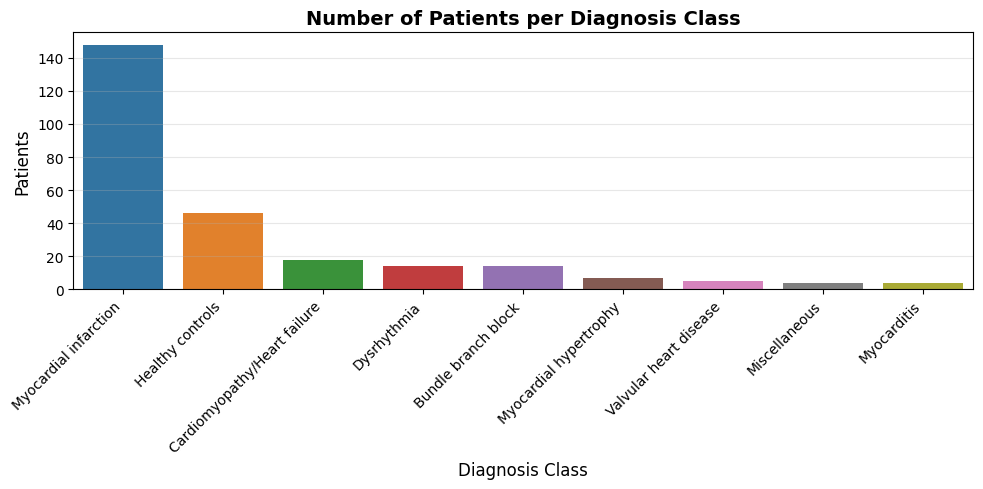

In [35]:

by_patient = df.groupby('patient_id', as_index=False)['diagnosis_class'].first()

plt.figure(figsize=(10,5))
sns.countplot(
    data=by_patient,
    x='diagnosis_class',
    order=by_patient['diagnosis_class'].value_counts().index,
    palette='tab10'
)

plt.title('Number of Patients per Diagnosis Class', fontsize=14, fontweight='bold')
plt.xlabel('Diagnosis Class', fontsize=12)
plt.ylabel('Patients', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
df.head()

## Labels of Model

In [36]:

encoder = LabelEncoder()
df['diagnosis_encoded'] = encoder.fit_transform(df['diagnosis_class'])

label_map = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print(label_map)

{'Bundle branch block': 0, 'Cardiomyopathy/Heart failure': 1, 'Dysrhythmia': 2, 'Healthy controls': 3, 'Miscellaneous': 4, 'Myocardial hypertrophy': 5, 'Myocardial infarction': 6, 'Myocarditis': 7, 'Valvular heart disease': 8}


## Use the signals

In [ ]:
X = []
y = []

for _, row in df.iterrows():
    sig = np.load(row['signal_path'])       
    max_len = 5000
    
    if sig.shape[0] > max_len:
        sig = sig[:max_len]
    else:
        pad = np.zeros((max_len - sig.shape[0], sig.shape[1]))
        sig = np.vstack([sig, pad])
    X.append(sig)
    y.append(row['diagnosis_encoded'])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int64)

print(X.shape, y.shape)

(513, 5000, 15) (513,)


## Training and Test set

In [40]:
# Get unique patients and perform splits
unique_patients = df['patient_id'].unique()
train_pat, test_pat = train_test_split(unique_patients, test_size=0.2, random_state=42)
val_pat, test_pat = train_test_split(test_pat, test_size=0.5, random_state=42)

# Create boolean masks
def mask(pids): return df['patient_id'].isin(pids)

# Create masks first and verify they're valid
train_mask = mask(train_pat)
val_mask = mask(val_pat)
test_mask = mask(test_pat)

# Print split sizes for verification
print(f"Train samples: {train_mask.sum()}")
print(f"Val samples: {val_mask.sum()}")
print(f"Test samples: {test_mask.sum()}")

# Use boolean indexing instead of .index[]
X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask], y[val_mask]
X_test,  y_test  = X[test_mask], y[test_mask]

Train samples: 400
Val samples: 59
Test samples: 54


In [41]:

def conv_block(x, filters, kernel_size=9, dilation=1, dropout_rate=0.1):
    x = layers.Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

def make_model(win=5000, ch=15, ncls=8):
    """
    Crea un modelo CNN 1D para clasificación multiclase de ECG.
    Parámetros:
      win: número de muestras por ventana (longitud temporal)
      ch: número de derivaciones (canales)
      ncls: número de clases (len(encoder.classes_))
    """
    inp = layers.Input(shape=(win, ch))
    
    x = conv_block(inp, 32, 9, 1)
    x = conv_block(x,   32, 9, 2)
    x = layers.MaxPool1D(2)(x)

    x = conv_block(x,   64, 9, 1)
    x = conv_block(x,   64, 9, 2)
    x = layers.MaxPool1D(2)(x)

    x = conv_block(x,  128, 9, 1)
    x = conv_block(x,  128, 9, 2)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    out = layers.Dense(ncls, activation='softmax')(x)
    
    model = models.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model


In [42]:
num_classes = len(encoder.classes_)
model = make_model(win=X_train.shape[1], ch=X_train.shape[2], ncls=num_classes)


In [43]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5000, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 5000, 32)       │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5000, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 5000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5000, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5000, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 5000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2500, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2500, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 2500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2500, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2500, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 2500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1250, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1250, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 1250, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 309,929 (1.18 MB)

 Trainable params: 309,033 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)

In [45]:
from tensorflow.keras.utils import to_categorical

num_classes = len(encoder.classes_)
y_train_oh = to_categorical(y_train, num_classes)
y_val_oh   = to_categorical(y_val,   num_classes)
y_test_oh  = to_categorical(y_test,  num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc', multi_label=True) 
    ]
)

callbacks = []  # You can add Keras callbacks here if needed

history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=40, batch_size=32,
    callbacks=callbacks, verbose=1
)

# Evaluación
test_metrics = model.evaluate(X_test, y_test_oh, verbose=0)
print(dict(zip(model.metrics_names, test_metrics)))


Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 783ms/step - accuracy: 0.6925 - auc: 0.4960 - loss: 1.3524 - val_accuracy: 0.6102 - val_auc: 0.2449 - val_loss: 1.9792
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 733ms/step - accuracy: 0.7200 - auc: 0.5629 - loss: 1.0718 - val_accuracy: 0.6102 - val_auc: 0.2982 - val_loss: 1.6708
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 666ms/step - accuracy: 0.7300 - auc: 0.6715 - loss: 0.9909 - val_accuracy: 0.5932 - val_auc: 0.2334 - val_loss: 1.6339
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 667ms/step - accuracy: 0.7275 - auc: 0.6890 - loss: 0.9642 - val_accuracy: 0.6102 - val_auc: 0.2402 - val_loss: 1.5396
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 587ms/step - accuracy: 0.7275 - auc: 0.7461 - loss: 0.9085 - val_accuracy: 0.6102 - val_auc: 0.2670 - val_loss: 1.5880
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 755ms/step - accuracy: 0.7175 - auc: 0.7169 - loss: 0.9566 - val_accuracy: 0.6102 - val_auc: 0.3034 - val_loss: 1.3672
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━